# Mini Data Project - Exploring AirBnB Data for Broke Couples
### Background Story and Premise:
Throughout my time studying in Amsterdam, I met and saw a lot of tourists. More than I could bargain for. This was because I lived near a very tourist-dense area where there were loads of international visitors and barely any Dutch people. (If you're asking how I managed to find an apartment to rent in this area, let's just say I got unbelievably lucky)

A category of tourists that I normally bumped into, besides families and drunken British boys in their mid 30's, were young couples. Usually hailing from other European countries, they wanted to temporarily escape their home, flying away to the most romantic honeymoon - and where else to spend this endeavour, if not for the one and only, premium adult playground that is Amsterdam?

There is a problem for these young couples, however. Amsterdam is a relatively expensive city. And when you're young, you're probably not going to be in the right spectrum when it comes to financial wellness - constantly asking about what this costs compared to that (well, unless you have rich parents or bought bitcoin back in 2012) - you're most likely going to be *broke*.

### EDA Aim:

This brief project will attempt to conduct an exploratory data analysis for this target market. We will try and flesh out the best options for a couple short on cash looking to rent an Airbnb in the city of Amsterdam. 

--------------------------------------------------------------------------------------------------------

### Notices
* **This dataset is outdated** - if we run the URL's that go to the original listing, some of them have been taken off the AirBnB website and is therefore not available anymore
* Geospatial information, such as the availability of maps, will be included in this dataset - via a python libary. However, if you're having a read right now, the data analyst responsible is currently in the process of learning how to do just that :) thank you for your patience.
* If you haved lived in Amsterdam before, and have any opinions about my interpretations, don't hesitate to contact me! 

--------------------------------------------------------------------------------------------------------

Below I implemented an ignore for warnings - this is of course not something i'd recommend but i ran into an issue with updating the data using 'loc' even though my code was basically correct *('settingwithcopy warning')*. I am still in the process of finding out why, but for now, I will install this 

In [1]:
import warnings
warnings.filterwarnings('ignore')

--------------------------------------------------------------------------------------------------------

In [2]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
listings_raw = pd.read_csv("Airbnb-data/listings_details.csv", low_memory= False)

In [4]:
listings_raw.shape

(20030, 96)

Since the dataset has too much columns, let's narrow it down to the most relevant ones

In [5]:
colnames = ["id", "listing_url", "price","review_scores_rating", "number_of_reviews", "name","neighbourhood","beds",
            "bathrooms", "property_type","room_type", "accommodates", "minimum_nights", "availability_365",
            "latitude", "longitude"]

listings = listings_raw[colnames]

In [6]:
listings.head() #Let's Peep the Dataset

,id,listing_url,price,review_scores_rating,number_of_reviews,name,neighbourhood,beds,bathrooms,property_type,room_type,accommodates,minimum_nights,availability_365,latitude,longitude
0,2818,https://www.airbnb.com/rooms/2818,$59.00,97.0,248,Quiet Garden View Room & Super Fast WiFi,Indische Buurt,2.0,1.5,Apartment,Private room,2,3,44,52.365755,4.941419
1,3209,https://www.airbnb.com/rooms/3209,$160.00,96.0,42,"Quiet apt near center, great view",Spaarndammer en Zeeheldenbuurt,2.0,1.0,Apartment,Entire home/apt,5,4,47,52.390225,4.873924
2,20168,https://www.airbnb.com/rooms/20168,$80.00,87.0,233,100%Centre-Studio 1 Private Floor/Bathroom,Grachtengordel,1.0,1.0,Townhouse,Entire home/apt,2,1,198,52.365087,4.893541
3,25428,https://www.airbnb.com/rooms/25428,$125.00,100.0,1,Lovely apt in City Centre (Jordaan),Grachtengordel,1.0,1.0,Apartment,Entire home/apt,3,14,141,52.373114,4.883668
4,27886,https://www.airbnb.com/rooms/27886,$150.00,99.0,171,"Romantic, stylish B&B houseboat in canal district",Westelijke Eilanden,1.0,1.0,Houseboat,Private room,2,2,199,52.386727,4.892078


----------------------------------------------------------------------------------------------------------------------

## Cleaning and Modifying the Data / Setting Limits

In [7]:
# Check missing values
listings.isnull().sum()

id                         0
listing_url                0
price                      0
review_scores_rating    2639
number_of_reviews          0
name                      38
neighbourhood           1653
beds                       7
bathrooms                 10
property_type              0
room_type                  0
accommodates               0
minimum_nights             0
availability_365           0
latitude                   0
longitude                  0
dtype: int64

In [8]:
#Clean Data with null values = beds, bathrooms 
listings.loc[:, 'beds'] = listings['beds'].dropna()
listings.loc[:, 'bathrooms'] = listings['bathrooms'].dropna()

In [9]:
#0.0 should also be treated as null and therefore should also be dropped
listings.drop(listings[listings['beds'] == 0].index, inplace = True)
listings.drop(listings[listings['bathrooms'] == 0].index, inplace = True)

In [14]:
# Convert price from object into int
listings.loc[:, "price"] = listings["price"].replace('[\$,]', '', regex=True).astype(float)

In [15]:
# Omit Data that has 0 for price value 
aboveZeroFilter = listings['price'] > 1
listings = listings[aboveZeroFilter]

In [16]:
#Let's convert the price from Dollars to Euros
#Let's also creat another price column - Indonesian Rupiah (personal use!)

from currency_converter import CurrencyConverter
c = CurrencyConverter()

def dollar_to_euro(x):
    return round(c.convert(x, 'USD','EUR'), 1)

def euro_to_idr(x):
    return round(c.convert(x, 'EUR','IDR'))

listings.loc[:, 'price'] = listings.loc[:, 'price'].apply(dollar_to_euro)
listings.loc[:, 'price_idr'] = listings.loc[:, 'price'].apply(euro_to_idr)

### Checking for outliers

<AxesSubplot:xlabel='price'>

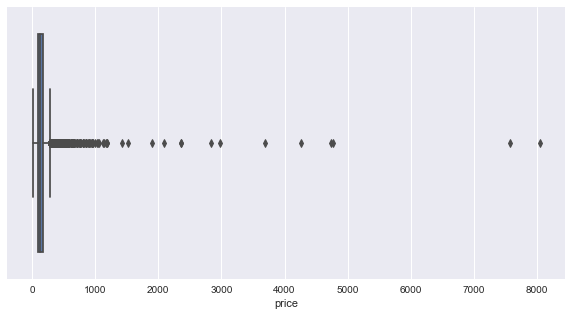

In [17]:
plt.figure(figsize = (10,5))
sns.boxplot(data=listings, x='price')

As we can see, there are a bunch of outliers. It never ceases to amaze me how there is actually a couple of listings above 8000€. 

One may argue that since we are performing analysis only for a target that is 'broke', we can just omit prices that do not fall within a certain range - but hold on - *just what do you mean by 'broke?'* This is of course relative to every person, but to keep it as unambigious as possible, in this analysis I will work with **what's below the 25th Percentile:**

In [18]:
brokelimit = round(listings['price'].quantile(q=0.25))
print(f'We will define the price limit as... {brokelimit}€')
print(f'Split that in two, and you get {brokelimit/2}€ per couple..')

eur_to_idr = c.convert(brokelimit/2, 'EUR','IDR')
print(f'Convert that into IDR, and you get RP {eur_to_idr} per couple..')

We will define the price limit as... 92€
Split that in two, and you get 46.0€ per couple..
Convert that into IDR, and you get RP 701542.32 per couple..


Personally, I think that the prices above are a good enough limit on what constitutes as a 'broke couple' price maximum.

In [19]:
price_mask = listings["price"] <= brokelimit
listings = listings[price_mask]
listingamount = listings['price'].count()
print(f'In total, we have {listingamount} listings that fall within the price range')

In total, we have 5042 listings that fall within the price range


<AxesSubplot:xlabel='price'>

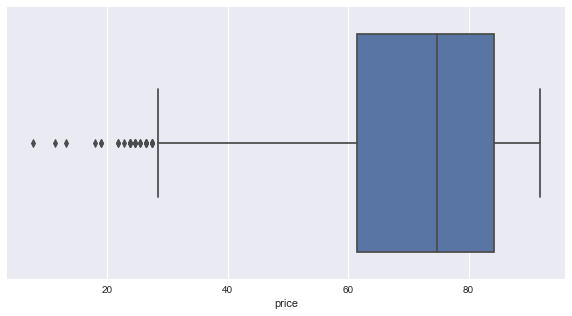

In [20]:
#Let's check the boxplot again - looks great to me!
plt.figure(figsize = (10,5))
sns.boxplot(data=listings, x='price')

**What's the price we can expect on average?**

In [21]:
pricemean = round(listings['price'].mean())
print(f'The average price, when setting the price limit of the data to the 25th Percentile is {pricemean}' + '$')

The average price, when setting the price limit of the data to the 25th Percentile is 71$


### Setting a filter which makes sure the listing is indeed for a couple
The 'accommodates' column indicates the maximum and minimum amount of guests a listing can hold. In our case, let's set it exactly to two.

In [22]:
coupleMask = listings['accommodates'] == 2
listings = listings[coupleMask]
listingcount = listings['id'].count()
print(f'In total, we have {listingcount} listings that fall within the couple criteria')

In total, we have 3821 listings that fall within the couple criteria


----------------------------------------------------------------------------------------------------------------------

## Exploratory Data Analysis

### A Closer Investigation of Neighbourhoods

Which Neighbourhood falls into our criteria the most? In other words, which neighbourhood has the most listings when it came to fitting into the criteria of a broke couple?

Text(0.5, 0, 'Neighbourhood Count')

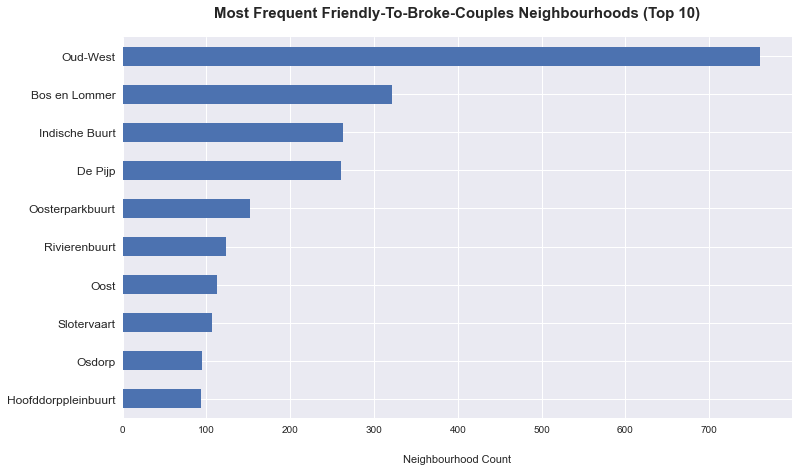

In [57]:
plt.figure(figsize=(12,7))
listings['neighbourhood'].value_counts().head(10).plot(kind='barh').invert_yaxis()
plt.yticks(fontsize = 12, rotation = 0)
plt.title('Most Frequent Friendly-To-Broke-Couples Neighbourhoods (Top 10)', fontsize= 15, fontweight = 'bold', pad = 20)
plt.xlabel('Neighbourhood Count', labelpad=20)

Looks like the neighbourhood of Oud-West takes the top spot by a big margin - This is no surprise because that area is primarily filled with residential apartments to begin with. But what about it's price? If you are a *truly broke* couple, you probably would prioritise price above everything else, correct?

Let us then ask, which areas have on average, the cheapest AirBnB listings when it comes to accommodating two people:

Text(0.5, 1.0, 'Top 10 Areas with Cheapest Listings (On Average)')

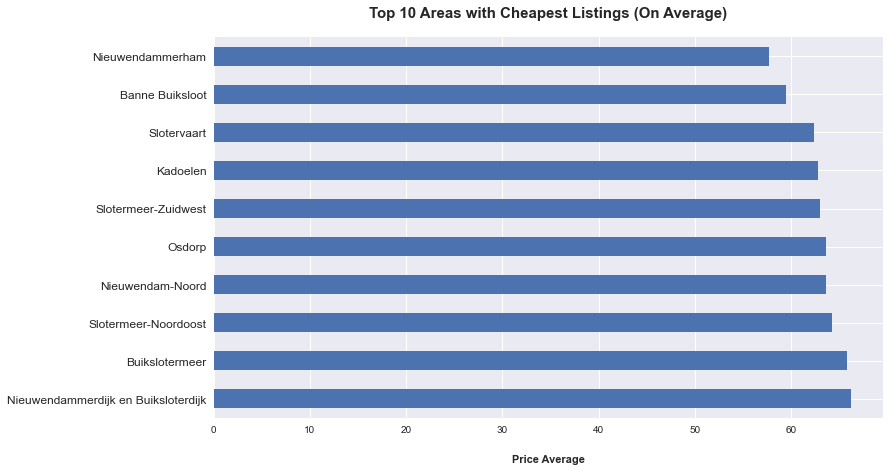

In [52]:
plt.figure(figsize=(12,7))
gbo = listings.groupby('neighbourhood')
gboPriceMean = gbo['price'].mean().nsmallest(10)

gboPriceMean.plot(kind='barh').invert_yaxis()
plt.yticks(fontsize = 12, rotation = 0)
plt.ylabel(None)
plt.xlabel('Price Average', labelpad=20, fontweight='bold')
plt.title('Top 10 Areas with Cheapest Listings (On Average)', fontsize= 15, fontweight = 'bold', pad = 20)

Unsuprisingly all of the areas are outside the city center - this is no surprise. In exchange for a cheaper listing we are going to have to sacrifice the convenience of being near the large tourist attractions.

### A Closer Investigation of Listing Types

Text(0.5, 1.0, 'Most Common Property Types for Broke Couples')

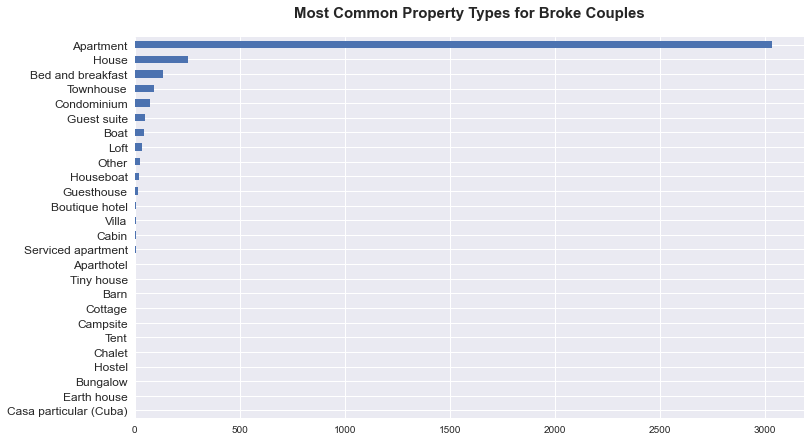

In [25]:
plt.figure(figsize=(12,7))
listings['property_type'].value_counts().plot(kind='barh').invert_yaxis()
plt.yticks(fontsize = 12, rotation = 0)
plt.ylabel(None)
plt.title('Most Common Property Types for Broke Couples', fontsize= 15, fontweight = 'bold', pad = 20)

Unsurprising that Apartment takes most of the available listings. There are a few odd findings though, such as 'condominium' and 'loft' popping into the frame. One would think that these property types are reserved for more luxurious listings, but that is not the case. It could be that the hosts purposefully put these in order to garner more attention? Quite a dirty trick, roughly speaking. 